# Proyecto de Churn Prediction - Feature Eng

### Resumen transformaciones

1. Limpieza básica (Antes del split)

 - Eliminar duplicados: df.drop_duplicates()

 - Corregir tipos de datos: convertir columnas mal tipadas (pd.to_numeric, pd.to_datetime)

 - Eliminar columnas irrelevantes (ej. customerID si no aporta valor)

2. EDA y análisis inicial

- Este paso es exploratorio, no modifica datos directamente, pero guía las decisiones posteriores

3. Separar features y target

4. Train/Test split

5. Tratamiento de valores nulos (Solo en train - fit/transform)

- Imputar numéricos: media o mediana

- Imputar categóricos: moda o "missing"

En valid/test: solo transform

Se puede hacer aquí en el notebook o dentro del pipeline si lo vas a reutilizar.

6. Outliers (opcional) (Solo en train)

- Detectar con Z-score o IQR

- Tratar si afectan mucho: eliminar o aplicar RobustScaler

En valid/test: transformar igual (¡no eliminar filas en valid!)

7. Corregir asimetría / skewness (Solo en train)

- Aplicar np.log1p() o PowerTransformer si es necesario

8. Encoding de variables categóricas (fit en train, transform en valid)

- pd.get_dummies() o OneHotEncoder()

- LabelEncoder() solo para variables ordinales o target

9. Escalado de variables numéricas (fit en train, transform en valid)

- StandardScaler() para modelos lineales, KNN, redes

- RobustScaler() si hay outliers

- No escalar si usas árboles (RandomForest, XGBoost...)

10. Balanceo de clases ( Solo en train)

- SMOTE, RandomOverSampler, etc.

- O usar class_weight='balanced' en modelos compatibles

11. Feature selection (fit en train, transform en valid)

- Eliminar columnas irrelevantes o muy correlacionadas

- Usar SelectKBest, RFE, o model.feature_importances_

12. Feature engineering (crear nuevas variables)

- Ratios, interacciones, extracciones...

Se puede hacer antes del split o dentro del pipeline si necesitas reproducibilidad

13. Validación y modelado

Una vez tienes:

- Datos imputados

- Codificados

- Escalados

- Balanceados (en train)

Ya puedes entrenar tu modelo y validarlo.

 14. Crear pipeline de producción

Agrupar todo lo anterior para predecir nuevos datos reales:


## Procesamiento y Feature Engineering

En la parte de procesamiento y feature engineering hay que tener en cuenta que:

- El objetivo es pasar de datos en crudo a datos listos para entrenar el modelo.

- Muchas transformaciones y decisiones vienen guiadas por el EDA, por ejemplo:

  - Si hay variables categóricas (strings) → convertirlas a numéricas mediante codificación.

  - Si existen sesgos o distribuciones muy diferentes → considerar transformaciones (por ejemplo, logarítmicas).

  - Si hay valores faltantes (missing values) → imputarlos o eliminarlos.

  - Si hay outliers → tratarlos o transformarlos.

  - Si hay correlaciones fuertes entre variables → evaluar la eliminación de alguna.

### Dónde aplicar cada transformación

Las transformaciones pueden realizarse en distintos momentos del flujo según su naturaleza:

**En todo el dataset (antes de dividir)**

Cuando son errores globales o de calidad de datos que afectan por igual a todas las partes del dataset.

Ejemplos: eliminar duplicados, corregir tipos de datos, limpiar categorías inconsistentes.

**Solo en el conjunto de entrenamiento**

Cuando son procesos que aprenden información de los datos (como medias, modas o valores de imputación).

Si se aplicaran antes del split, podrían corromper el aprendizaje del modelo (data leakage).

Ejemplos: imputación, detección y eliminación de outliers, selección de variables basada en el target, balanceo de clases.

**Dentro del Feature Pipeline**

Cuando son transformaciones que deben repetirse exactamente igual al aplicar el modelo sobre datos nuevos.

Ejemplos: escalado, codificación, imputación, transformaciones numéricas, creación de nuevas características.

**NOTA**: El pipeline se entrena solo con los datos de entrenamiento y luego se usa para transformar tanto los datos de validación como los nuevos.

# Entrenamiento del modelo

## Selección de modelos y evaluación

En esta etapa el objetivo es entrenar varios modelos diferentes:
- Lineales
- Kernel
- Distancias
- Arbol
- Boosting

Para ver cuál se puede adaptar mejor a nuestros datos.

Se comparan en base a las métricas de evaluación.

En este caso, al ser clasificación desbalanceada priorizamos:
- Recall
- F1-score
- ROC AUC

In [29]:
# importar librerías
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split


In [30]:
# Cargamos datos train-test de features, X e Y

X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()  # Para convertir a Series

X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

In [31]:
lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0], shape=(1409,))

In [32]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(1409,))

In [33]:
# Entrenamos modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1035
           1       0.50      0.76      0.60       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.79      0.73      0.75      1409

ROC AUC: 0.8155829393681056

Decision Tree
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1035
           1       0.49      0.51      0.50       374

    accuracy                           0.73      1409
   macro avg       0.65      0.66      0.65      1409
weighted avg       0.73      0.73      0.73      1409

ROC AUC: 0.6726626882637113

Random Forest
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1035
           1       0.53      0.53      0.53       374

    accuracy                           0.75      1409
   macro avg       0.

/Users/cdonairem/Documents/Workspace/proyecto_churn_prediction_oct_25/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:06:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1035
           1       0.51      0.55      0.53       374

    accuracy                           0.74      1409
   macro avg       0.67      0.68      0.67      1409
weighted avg       0.75      0.74      0.74      1409

ROC AUC: 0.7792580536826061


In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

print("KNN")
print(classification_report(y_test, y_pred_knn))
print("ROC AUC:", roc_auc_score(y_test, y_proba_knn))

# SVM - Cuidado, tarda mucho en entrenar!
svm = SVC(probability=True, kernel='rbf', C=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)[:, 1]

print("\nSVM")
print(classification_report(y_test, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_test, y_proba_svm))

KNN
              precision    recall  f1-score   support

           0       0.85      0.71      0.78      1035
           1       0.45      0.66      0.53       374

    accuracy                           0.70      1409
   macro avg       0.65      0.68      0.65      1409
weighted avg       0.74      0.70      0.71      1409

ROC AUC: 0.7315701774781058

SVM
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1035
           1       0.52      0.70      0.59       374

    accuracy                           0.75      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.75      0.76      1409

ROC AUC: 0.7917099382572528

SVM
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1035
           1       0.52      0.70      0.59       374

    accuracy                           0.75      1409
   macro avg       0.70      0.73      0.71      1409
weig

## Optimización de hiperparámetros

### Logistic Regresion

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

logreg = LogisticRegression()

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],   # fuerza de regularización
    'penalty': ['l1', 'l2', 'elasticnet'],
}

grid_logreg = GridSearchCV(logreg, param_grid_logreg, scoring='f1', cv=5, n_jobs=-1)
grid_logreg.fit(X_train, y_train)

print("Best params (Logistic):", grid_logreg.best_params_)
print("Best score (f1):", grid_logreg.best_score_)

Best params (Logistic): {'C': 0.01, 'penalty': 'l2'}
Best score (f1): 0.7709949906235098


/Users/cdonairem/Documents/Workspace/proyecto_churn_prediction_oct_25/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
50 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cdonairem/Documents/Workspace/proyecto_churn_prediction_oct_25/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cdonairem/Documents/Workspace/proyecto_churn_prediction_oct_25/venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *ar

### SVM

In [36]:
# Tarda mucho

from sklearn.model_selection import RandomizedSearchCV # hace que tarde menos
from sklearn.svm import SVC
from scipy.stats import uniform

svm = SVC(probability=True)

param_grid_svm = {
    'C': uniform(0.1, 10),  # valores entre 0.1 y 10
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

rand_svm = RandomizedSearchCV(
    svm,
    param_grid_svm,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42
)

rand_svm.fit(X_train, y_train)

print("Best params (SVM):", rand_svm.best_params_)
print("Best score (f1):", rand_svm.best_score_)

Best params (SVM): {'C': np.float64(8.424426408004217), 'gamma': 'auto', 'kernel': 'rbf'}
Best score (f1): 0.8023308455530802


### XGBoost

In [37]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_xgb = RandomizedSearchCV(xgb, param_grid_xgb, scoring='f1', cv=5, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best params (XGBoost):", grid_xgb.best_params_)
print("Best score (f1):", grid_xgb.best_score_)

/Users/cdonairem/Documents/Workspace/proyecto_churn_prediction_oct_25/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:08:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/cdonairem/Documents/Workspace/proyecto_churn_prediction_oct_25/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:08:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/cdonairem/Documents/Workspace/proyecto_churn_prediction_oct_25/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:08:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/cdonairem/Documents/Workspace/proyecto_churn_predictio

Best params (XGBoost): {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1}
Best score (f1): 0.818946596074006


In [38]:
xgb_tuned = XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8)
xgb_tuned.fit(X_train, y_train)
y_pred = xgb_tuned.predict(X_test)

## Métricas evaluación

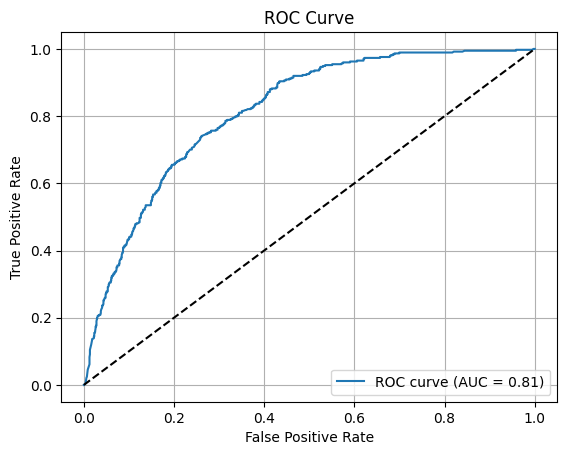

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = xgb_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

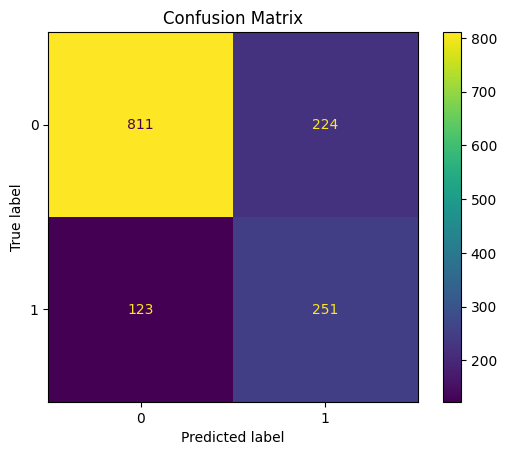

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1035
           1       0.53      0.67      0.59       374

    accuracy                           0.75      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.75      0.76      1409



## Mejorar con threshold

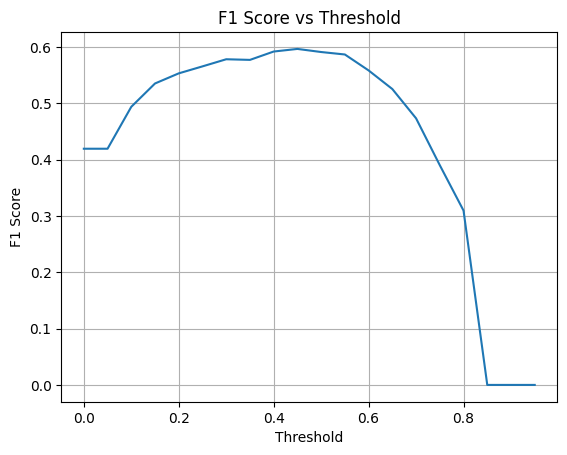

In [42]:
# Paso 1: Obtener probabilidades
y_proba = xgb_tuned.predict_proba(X_test)[:, 1]

# Paso 2: Probar diferentes thresholds
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.0, 1.0, 0.05)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid()
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.46      0.63      1035
           1       0.39      0.95      0.55       374

    accuracy                           0.59      1409
   macro avg       0.68      0.71      0.59      1409
weighted avg       0.81      0.59      0.61      1409



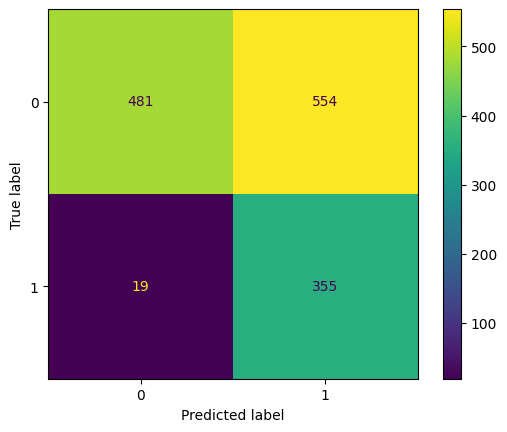

In [43]:
# Paso 3: Aplicar el mejor threshold
# Supón que el mejor threshold es 0.35
best_thresh = 0.20
y_pred_thresh = (y_proba >= best_thresh).astype(int)

# Evaluar con nuevo umbral
print(classification_report(y_test, y_pred_thresh))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.show()

## Guardar modelo

In [44]:
import joblib
import os

# Asegurarnos de que la carpeta models/ existe (ruta relativa desde notebooks/)
os.makedirs("../models", exist_ok=True)

# Guardamos el modelo en un archivo dentro de la carpeta models/
joblib.dump(xgb_tuned, "../models/xgb_model.pkl")
print("Modelo guardado en ../models/xgb_model.pkl")


Modelo guardado en ../models/xgb_model.pkl


# Predicción de nuevos datos

In [45]:
import joblib

# Cargar el modelo desde archivo
modelo = joblib.load("../models/xgb_model.pkl")

# Obtener probabilidades de clase positiva
y_proba = modelo.predict_proba(X_test)[:, 1]

# Aplicar threshold personalizado
optimal_threshold = 0.25
y_pred = (y_proba >= optimal_threshold).astype(int)

# Resultado final
y_pred

# # Predicciones de clase sin threshold
# y_pred = modelo.predict(X_test)

# # Predicciones de probabilidad (opcional, para ROC AUC, etc.)
# y_proba = modelo.predict_proba(X_test)[:, 1]

# y_pred

array([0, 1, 0, ..., 1, 0, 0], shape=(1409,))

              precision    recall  f1-score   support

           0       0.95      0.52      0.67      1035
           1       0.41      0.92      0.57       374

    accuracy                           0.63      1409
   macro avg       0.68      0.72      0.62      1409
weighted avg       0.80      0.63      0.64      1409



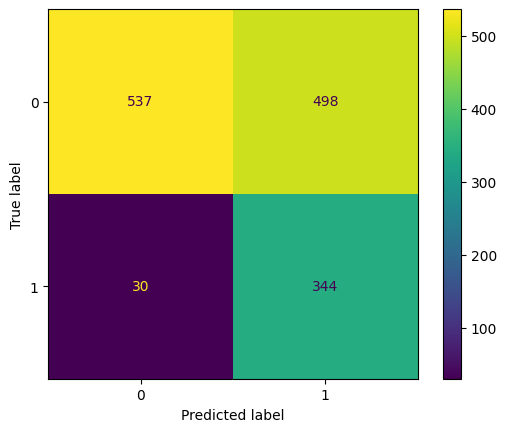

In [46]:
# Evaluar con nuevo umbral
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Pipelines

## Training pipeline

In [47]:
# training_pipeline.py

import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

def train_model():
    df = pd.read_csv("../data/train_processed.csv")

    X = df.drop("Churn", axis=1)
    y = df["Churn"]

    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)
    model.fit(X_train, y_train)

    joblib.dump(model, "../models/final_model.pkl")
    print("Modelo entrenado y guardado correctamente.")

if __name__ == "__main__":
    train_model()


FileNotFoundError: [Errno 2] No such file or directory: '../data/train_processed.csv'

## Inference Pipeline

In [ ]:
# inference_pipeline.py

import pandas as pd
import joblib

def predict_new_data(new_data_csv):
    # Cargar el modelo desde archivo
    modelo = joblib.load("xgb_model.pkl")

    # Obtener probabilidades de clase positiva
    y_proba = modelo.predict_proba(new_data_csv)[:, 1]

    # Aplicar threshold personalizado
    optimal_threshold = 0.25
    y_pred = (y_proba >= optimal_threshold).astype(int)

    # Resultado final
    y_pred

    return pd.DataFrame({
        "Prediction": y_pred,
        "Probability":y_proba
    })

# Ejemplo
df_preds = predict_new_data("data/new_data_processed.csv")
print(df_preds.head())
